In [63]:
import pandas as pd
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [64]:
# Visualize the data with the existing index
def visualize_data(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['crew_demand'], label='Crew Demand')
    plt.title('Crew Demand Over Time')
    plt.xlabel('Date')
    plt.ylabel('Crew Demand')
    plt.legend()
    plt.show()


In [65]:
def test_stationarity(series):
    # Ensure the series is numeric
    if not pd.api.types.is_numeric_dtype(series):
        raise ValueError("Input series must be numeric for stationarity testing.")

    result = adfuller(series.dropna())  # Drop NaN values
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
    if result[1] <= 0.05:
        print("The data is stationary.")
    else:
        print("The data is not stationary.")


In [66]:

# Make the data stationary
def make_stationary(series):
    diff_series = series.diff().dropna()
    return diff_series


In [67]:

# Plot ACF and PACF
def plot_acf_pacf(series):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series, lags=20, ax=plt.gca())
    plt.title('ACF Plot')

    plt.subplot(122)
    plot_pacf(series, lags=20, ax=plt.gca())
    plt.title('PACF Plot')

    plt.tight_layout()
    plt.show()

In [68]:

# Build ARIMA model
def build_arima_model(series, p, d, q):
    model = ARIMA(series, order=(p, d, q))
    model_fit = model.fit()
    print(model_fit.summary())
    return model_fit


In [69]:
def evaluate_model(model_fit, series):
    # Extract the numeric series used in ARIMA modeling
    actual = series['crew_demand']  # Replace 'crew_demand' with your target column name
    predictions = model_fit.predict(start=actual.index[0], end=actual.index[-1])
    
    # Align predictions with actual values
    predictions = predictions[:len(actual)]
    
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    
    print('Mean Absolute Error (MAE):', mae)
    print('Mean Squared Error (MSE):', mse)
    print('Root Mean Squared Error (RMSE):', rmse)
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label='Actual', color='blue')
    plt.plot(actual.index, predictions, label='Predictions', color='orange', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Crew Demand')
    plt.title('Actual vs Predictions')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Return predictions for further use
    return predictions

In [71]:

# Main workflow
input_csv = "../data/output_with_crew_demand1.csv"  # Replace with your input CSV file path

df = pd.read_csv(input_csv)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

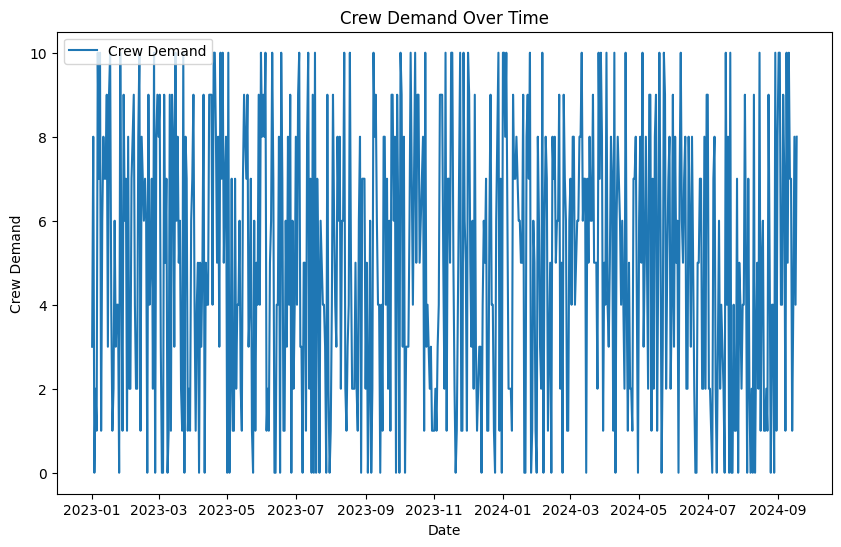

In [72]:
visualize_data(df)



In [73]:
test_stationarity(df['crew_demand'])


ADF Statistic: -25.317755817667265
p-value: 0.0
Critical Value (1%): -3.4408393249134326
Critical Value (5%): -2.86616806030903
Critical Value (10%): -2.569234676071002
The data is stationary.


In [74]:

# Make the data stationary if needed
df_stationary = make_stationary(df['crew_demand'])


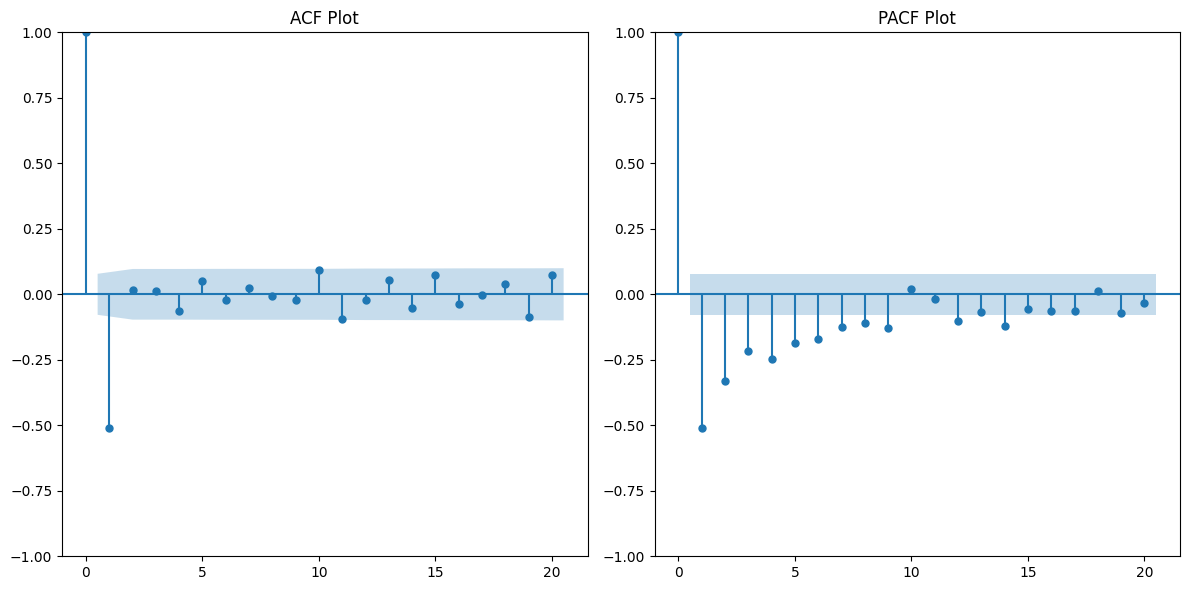

In [75]:

# Plot ACF and PACF
plot_acf_pacf(df_stationary)


In [19]:
def build_arima_model(df, p, d, q):
    # Ensure the DataFrame index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Ensure the data has a daily frequency
    df = df.asfreq('D')

    # Fit the ARIMA model
    model = ARIMA(df['crew_demand'], order=(p, d, q))
    model_fit = model.fit()
    print(model_fit.summary())
    return model_fit


In [76]:
def build_sarima_model(df, p, d, q, P, D, Q, m):
    """
    Build and fit a SARIMA model.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with a datetime index and a target column named 'crew_demand'.
        p, d, q (int): ARIMA parameters.
        P, D, Q (int): Seasonal ARIMA parameters.
        m (int): The number of periods in a full seasonal cycle (e.g., 12 for monthly seasonality).
    
    Returns:
        model_fit: Fitted SARIMA model.
    """
    import pandas as pd

    # Ensure the DataFrame index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Ensure the data has a daily frequency
    df = df.asfreq('D')
    
    # Fit the SARIMA model
    model = SARIMAX(
        df['crew_demand'], 
        order=(p, d, q), 
        seasonal_order=(P, D, Q, m), 
        enforce_stationarity=False, 
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)
    print(model_fit.summary())
    return model_fit

In [83]:
#Example values; adjust based on ACF/PACF analysis
m = 12
P,D,Q = 2,0,1
p,d,q = 1,0,1
model_fit = build_sarima_model(df, p, d, q,P,D,Q,m)
#model_fit = build_arima_model(df, p, d, q)


                                     SARIMAX Results                                      
Dep. Variable:                        crew_demand   No. Observations:                  627
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood               -1578.776
Date:                            Wed, 22 Jan 2025   AIC                           3169.552
Time:                                    17:40:23   BIC                           3195.953
Sample:                                01-01-2023   HQIC                          3179.828
                                     - 09-18-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3941      0.522      0.754      0.451      -0.630       1.418
ma.L1         -0.4038      0.521   

Mean Absolute Error (MAE): 2.9140752944299355
Mean Squared Error (MSE): 11.71754964187628
Root Mean Squared Error (RMSE): 3.4230906563917176


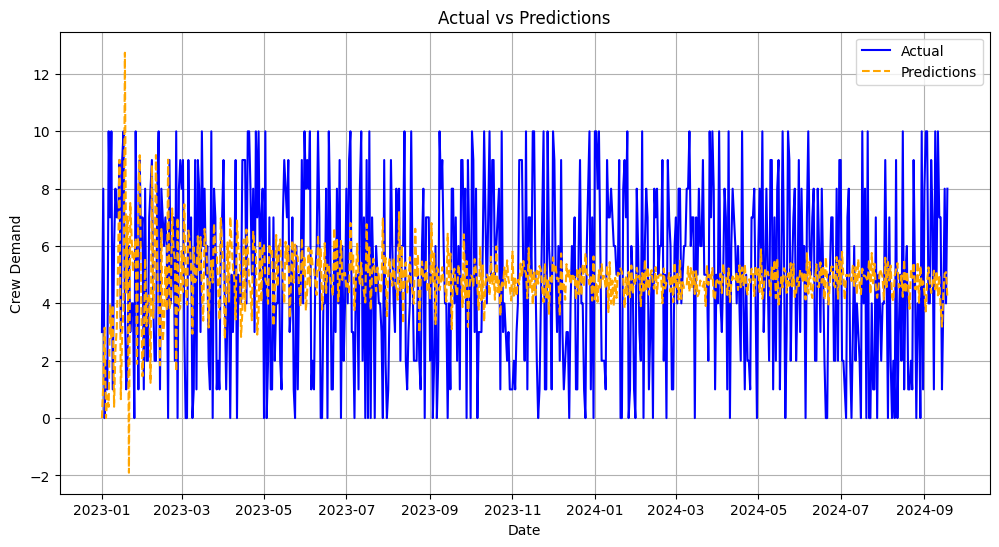

date
2023-01-01    0.000000
2023-01-02    1.182304
2023-01-03    3.152782
2023-01-04    0.000013
2023-01-05    0.788194
                ...   
2024-09-14    3.188104
2024-09-15    4.369857
2024-09-16    5.032986
2024-09-17    5.089822
2024-09-18    4.198239
Freq: D, Name: predicted_mean, Length: 627, dtype: float64

In [84]:

evaluate_model(model_fit, df)
